In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, jaccard_score, fowlkes_mallows_score, rand_score

## 一、数据预处理

### 1.1 加载数据

In [18]:
data = pd.read_csv('./dataset/kddcup.data_10_percent_corrected', sep=',')

columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'outcome'
]
discrete_columns = [
    'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login'
]
data.columns = columns

### 1.2 离散数据编码

In [19]:
LE = LabelEncoder()

X = data.drop('outcome', axis=1)
for column in discrete_columns:
    X[column] = LE.fit_transform(X[column]).astype(np.float64)

## 二、模型自定义实现

In [20]:
class MyKMeans:
    def __init__(self, n_clusters=5, n_init=10) -> None:
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.centroids = None
        self.labels_ = None
    
    def fit(self, X: pd.DataFrame) -> None:
        '''
        训练KMeans模型
        '''
        
        data = X

        self.centroids = self._init_centroids(data)
        
        for _ in range(self.n_init):
            labels = self._assign_clusters(data)
            new_centroids = self._update_centroids(data, labels)
            
            if new_centroids.equals(self.centroids):
                break
            
            self.centroids = new_centroids

        self.labels_ = labels
    

    def _init_centroids(self, data: pd.DataFrame) -> pd.DataFrame:
        '''
        随机初始化聚类中心
        '''

        centroids_indices = data.sample(n=self.n_clusters, replace=False).index
        centroids = data.loc[centroids_indices]

        return centroids
    
    
    def _assign_clusters(self, data: pd.DataFrame) -> pd.Series:
        '''
        分配每个样本到最近的聚类中心
        '''

        distances = ((data.values - self.centroids.values[:, np.newaxis])**2).sum(axis=2)**0.5
        labels = pd.Series(np.argmin(distances, axis=0))

        return labels
    
    
    def _update_centroids(self, data: pd.DataFrame, labels: pd.Series) -> pd.DataFrame:
        '''
        更新聚类中心为每个簇的平均值
        '''

        new_centroids = pd.DataFrame([data[labels == i].mean(axis=0) for i in range(self.n_clusters)])

        return new_centroids

## 三、模型预测与评估

### 3.1 模型预测

In [21]:
all_result = []
for n in range(2, 11):
    my_model = MyKMeans(n_clusters=n, n_init=10)
    my_model.fit(X)
    all_result.append([n, my_model.labels_])

### 3.2 模型评估

In [6]:
label_normal = ['normal.']
label_probe = ['ipsweep.', 'mscan.', 'nmap.', 'portsweep.', 'saint.', 'satan.']
label_dos = [
    'apache2.', 'back.', 'land.', 'neptune.', 'mailbomb.', 'pod.', 'processtable.',
    'smurf.', 'teardrop.', 'udpstorm.'
]
label_u2r = [
    'buffer_overflow.', 'httptunnel.','loadmodule.', 'perl.',
    'ps.', 'rootkit.', 'sqlattack.', 'xterm.'
]
label_r2l = [
    'ftp_write.', 'guess_passwd.', 'imap.', 'multihop.', 'named.', 'phf.',
    'sendmail.', 'snmpgetattack.', 'snmpguess.', 'spy.', 'warezclient.', 'warezmaster.',
    'worm.', 'xlock.', 'xsnoop.'
]

y = data['outcome'].copy()
y[y.isin(label_normal)] = 0
y[y.isin(label_probe)] = 1
y[y.isin(label_dos)] = 2
y[y.isin(label_u2r)] = 3
y[y.isin(label_r2l)] = 4
y = y.astype(np.int32)

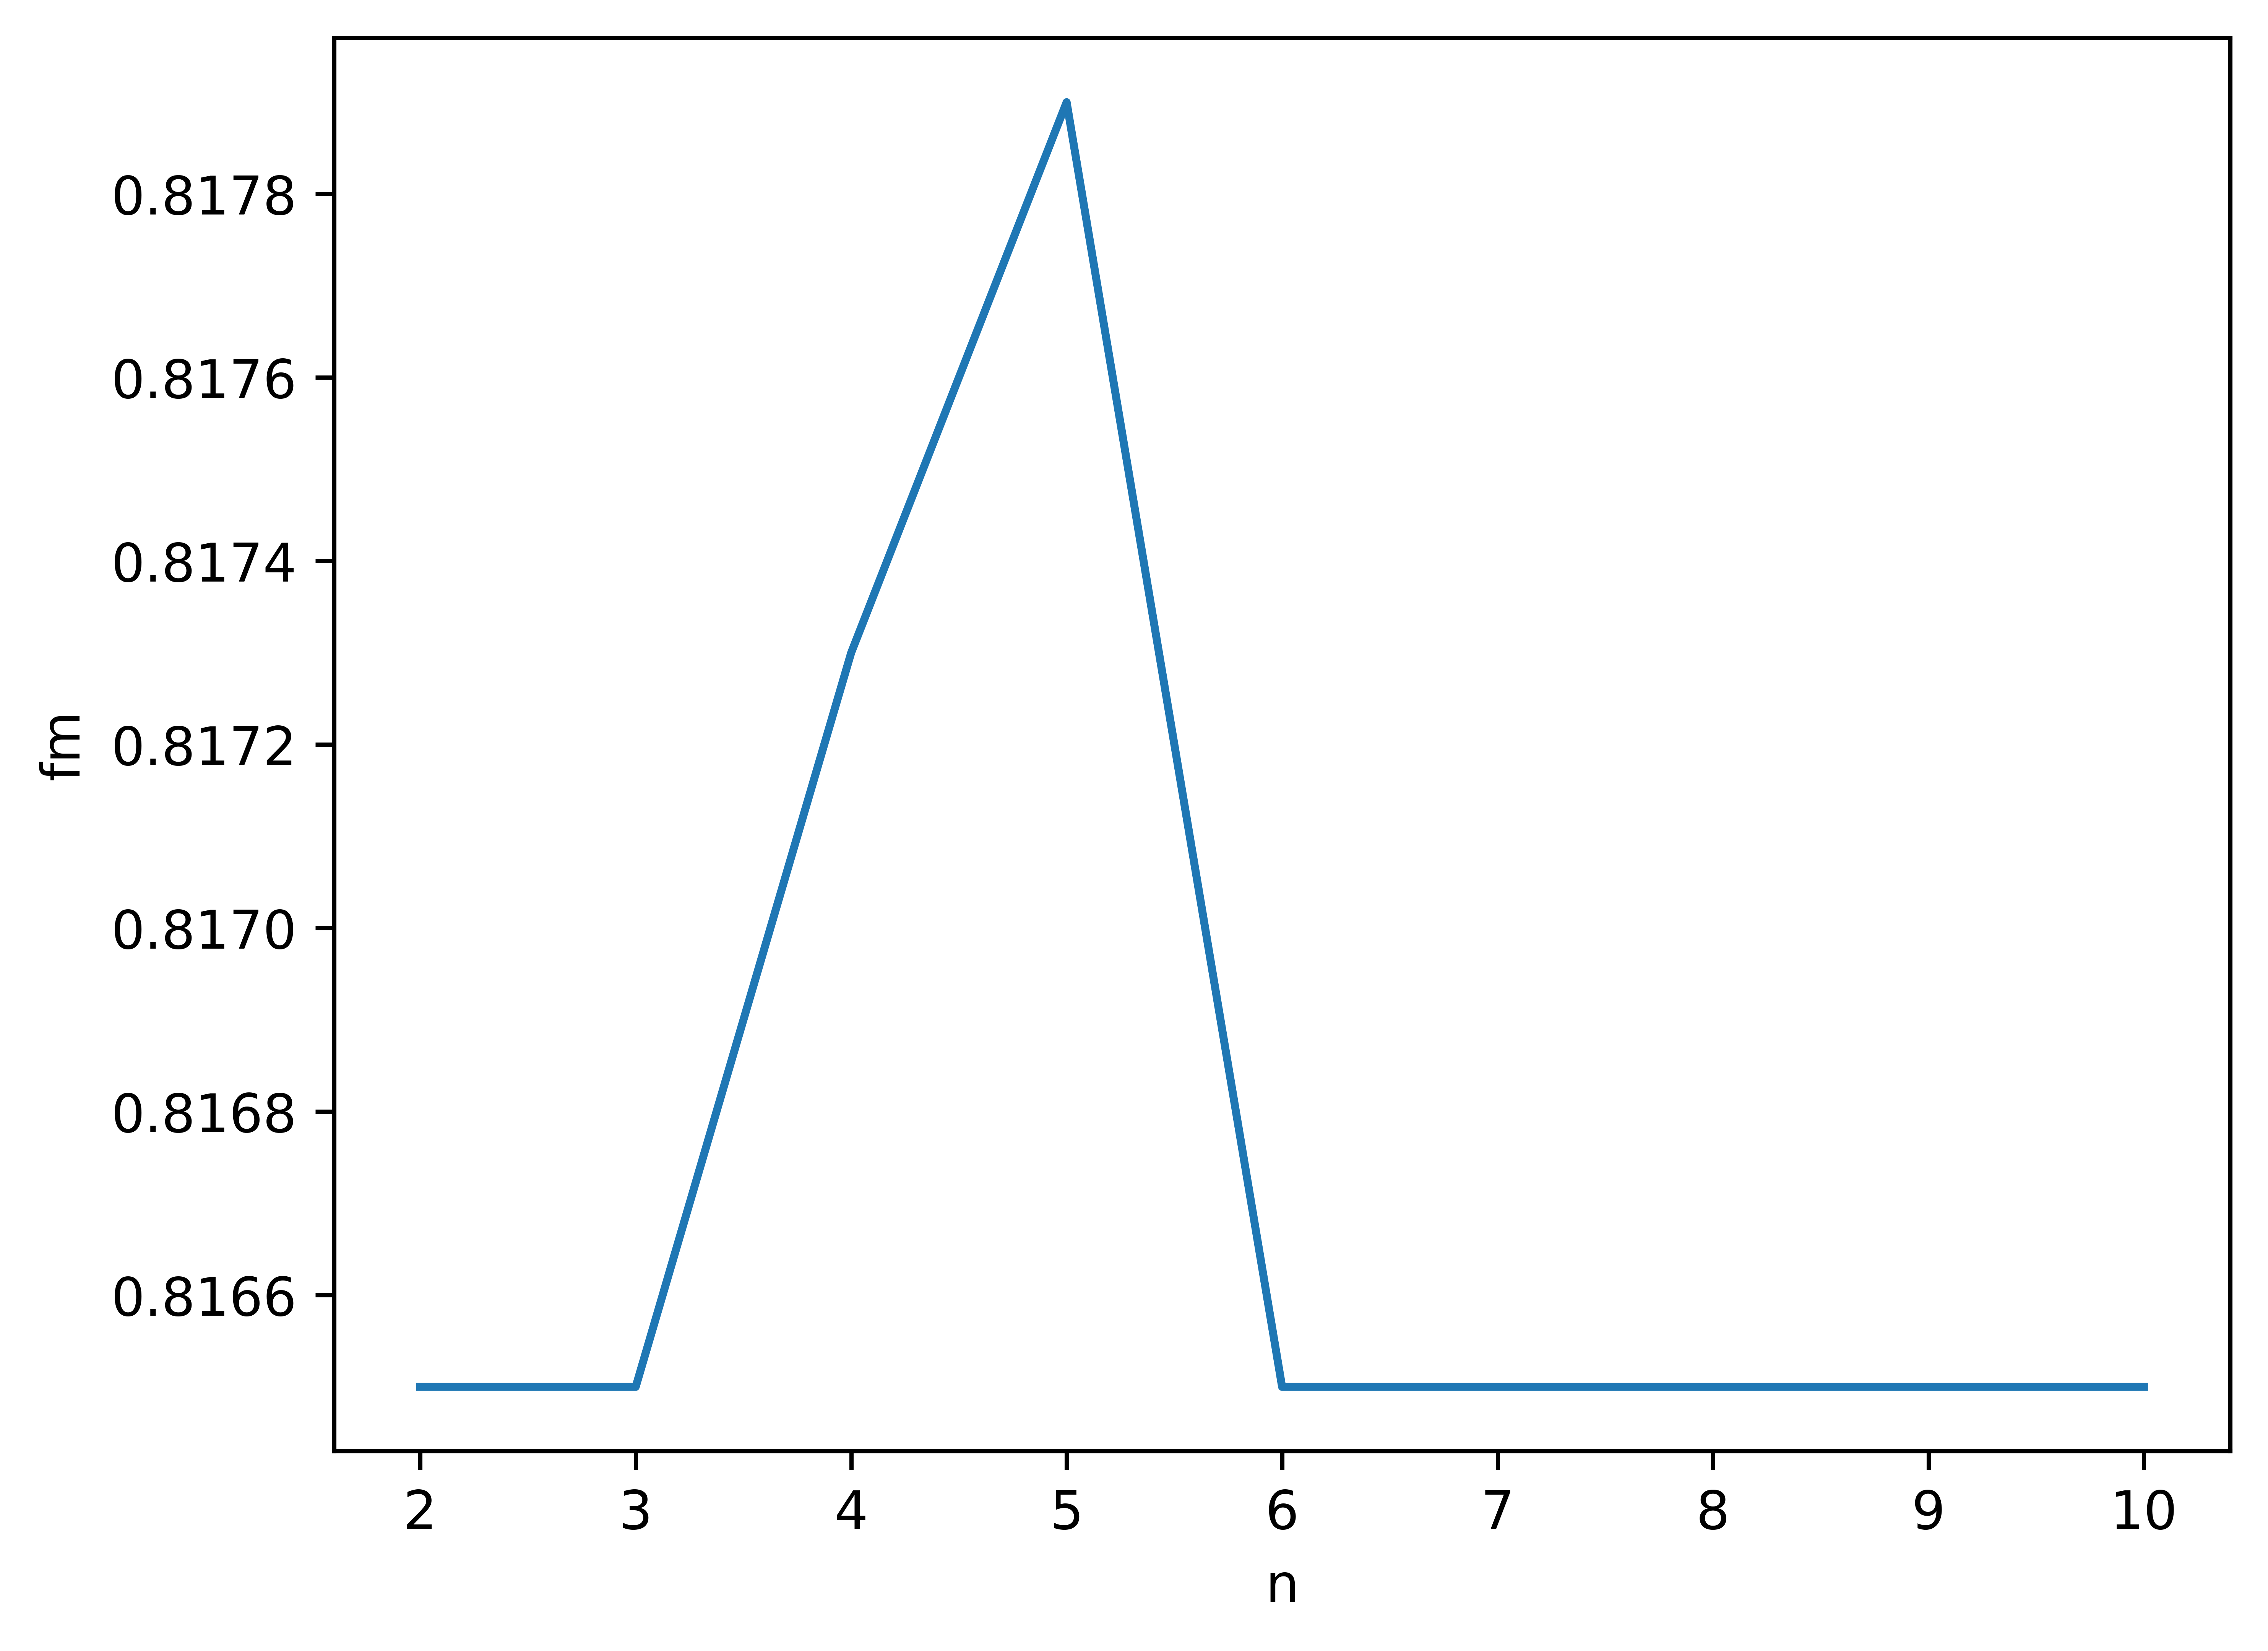

In [28]:
scat_n = []
scat_fm = []
for it in all_result:
    n, pred = it
    scat_n.append(n)
    scat_fm.append(round(fowlkes_mallows_score(y, pred), 4))

fig = plt.figure(dpi=1000)
plt.plot(scat_n, scat_fm)
plt.xlabel('n')
plt.ylabel('fm')
plt.show()

## 四、与标准包的对比

In [23]:
std_model = KMeans(n_clusters=5, n_init=10)
std_model.fit(X)

KMeans(n_clusters=5, n_init=10)

In [29]:
std_result = std_model.labels_

jc = jaccard_score(y, std_result, average='micro')
fm = fowlkes_mallows_score(y, std_result)
ri = rand_score(y, std_result)

print(f"Jaccard Coefficient (JC): {jc:.2f}")
print(f"Fowlkes-Mallows Index (FM): {fm:.4f}")
print(f"Rand Index (RI): {ri:.2f}")

Jaccard Coefficient (JC): 0.11
Fowlkes-Mallows Index (FM): 0.8167
Rand Index (RI): 0.67


## 五、大数据性能测试

In [10]:
fulldata = pd.read_csv('./dataset/kddcup.data.corrected', sep=',')

In [11]:
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'outcome'
]
discrete_columns = [
    'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login'
]
fulldata.columns = columns

LE = LabelEncoder()

big_X = fulldata.drop('outcome', axis=1)
for column in discrete_columns:
    big_X[column] = LE.fit_transform(big_X[column]).astype(np.float64)

In [12]:
now_model = KMeans(n_clusters=5, n_init=10)
now_model.fit(X)

KMeans(n_clusters=5, n_init=10)

In [13]:
now_my_model = MyKMeans(n_clusters=5, n_init=10)
now_my_model.fit(X)

In [31]:
big_y = LE.fit_transform(fulldata['outcome']).astype(np.int32)
fm_std = fowlkes_mallows_score(big_y, now_model.labels_)
fm_my = fowlkes_mallows_score(big_y, now_my_model.labels_)

print(f"标准包 FM 指数: {fm_std:.4f}")
print(f"自实现 FM 指数: {fm_my:.4f}")

标准包 FM 指数: 0.6449
自实现 FM 指数: 0.7517
